In [73]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

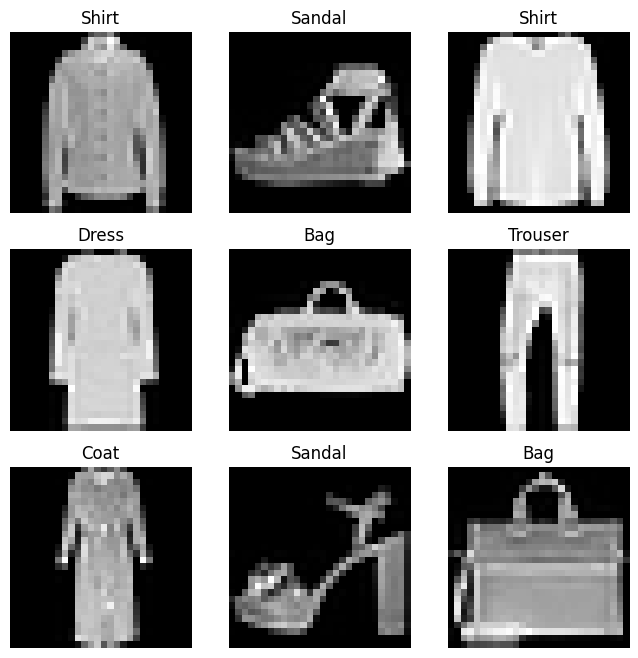

In [74]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [75]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [76]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


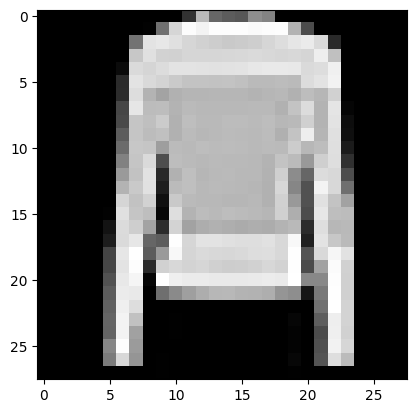

Label: 2


In [77]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# CNN

Shape de la imagen después de la convolución: torch.Size([1, 6, 26, 26])
Shape de la imagen después del pooling: torch.Size([1, 6, 13, 13])


Text(0.5, 1.0, 'Imagen con Pooling')

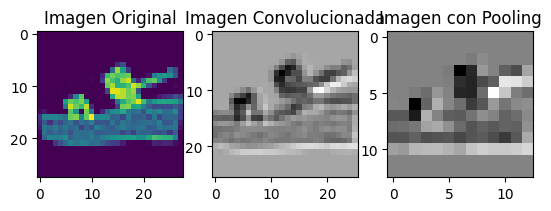

In [78]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que training_data[12][0] es una imagen con 1 canal
imagen_demo = training_data[12][0]  # Seleccionar imagen

# Asegúrate de que la imagen tenga 1 canal, ya que estamos usando Conv2d con in_channels=1
conv_demo = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
conv_image = conv_demo(imagen_demo.unsqueeze(0))  # Añadir dimensión de batch
print(f"Shape de la imagen después de la convolución: {conv_image.shape}")

pool_demo = nn.MaxPool2d(2, 2)
pool_image = pool_demo(conv_image)
print(f"Shape de la imagen después del pooling: {pool_image.shape}")

# Preparar imágenes para visualización
# Convertimos la imagen original de PyTorch tensor a un formato adecuado para mostrar
img = imagen_demo.permute(1, 2, 0).detach().numpy() / 2 + 0.5  # Convertimos para visualizar en rango [0, 1]

# Seleccionar el primer canal de la salida de la convolución (6 canales en total)
conv_img = conv_image[0, 0].detach().numpy()  # Primer canal de la convolución

# Seleccionar el primer canal de la imagen después del pooling
pool_img = pool_image[0, 0].detach().numpy()  # Primer canal después del pooling

# Mostrar las imágenes
fig, axs = plt.subplots(1, 3)

# Mostrar la imagen original
axs[0].imshow(img)
axs[0].set_title("Imagen Original")

# Mostrar la imagen convolucionada
axs[1].imshow(conv_img, cmap='gray')
axs[1].set_title("Imagen Convolucionada")

# Mostrar la imagen después del pooling
axs[2].imshow(pool_img, cmap='gray')  # Imagen después de MaxPooling
axs[2].set_title("Imagen con Pooling")

# Mostrar el gráf


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa convolucional 1: imagen de 28x28x1 a 26x26x6 (escala de grises, 1 canal)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3) 
        self.pool = nn.MaxPool2d(2, 2)  # Pooling 2x2
        # Capa convolucional 2: de 13x13x6 a 9x9x16
        self.conv2 = nn.Conv2d(6, 16, 5)  
        # Capa totalmente conectada: de 4x4x16 a 120 neuronas
        self.fc1 = nn.Linear(16 * 4 * 4, 120) 
        # Capa totalmente conectada 2: de 120 a 84
        self.fc2 = nn.Linear(120, 84)
        # Capa de salida: de 84 a 10 (clases)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Aplicamos la primera capa convolucional + pooling
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Pool
        # Aplicamos la segunda capa convolucional + pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Pool
        # Aplanamos la salida para pasarla a la red completamente conectada
        x = torch.flatten(x, 1)  # Aplana todo excepto el batch
        # Capa totalmente conectada 1
        x = F.relu(self.fc1(x))
        # Capa totalmente conectada 2
        x = F.relu(self.fc2(x))
        # Capa de salida
        x = self.fc3(x)
        return x

cnn = CNN()


In [80]:
import torch.optim as optim
import torch.nn as nn

# Suponiendo que las etiquetas están codificadas como enteros (categorías):
criterion = nn.CrossEntropyLoss()  # Función de pérdida para clasificación multiclase

# Usar SGD como optimizador
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9) 

In [81]:
EPOCHS = 5
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = cnn(inputs)
        # backward
        loss = criterion(outputs, labels)
        loss.backward()
        # optimizacion
        optimizer.step()

        # print statistics
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_dataloader)  # Calculate average loss for the epoch
    losses.append(average_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {average_loss:.4f}")

print('Entrenamiento finalizado')

Epoch 1/5, Loss: 1.0748
Epoch 2/5, Loss: 0.4931
Epoch 3/5, Loss: 0.4114
Epoch 4/5, Loss: 0.3695
Epoch 5/5, Loss: 0.3425
Entrenamiento finalizado


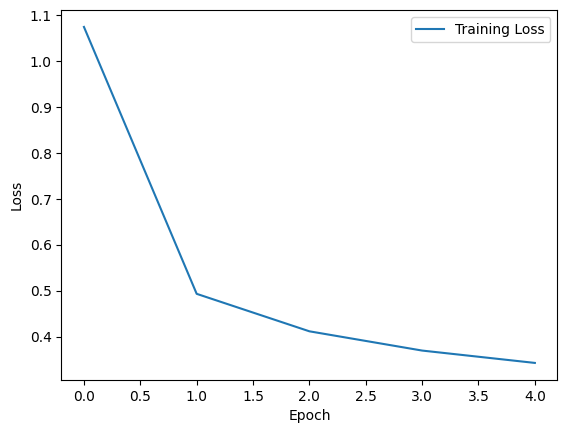

In [82]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
torch.save(cnn.state_dict(), './cnn_ropa.pth')

In [84]:
cnn_loaded = CNN()
cnn_loaded.load_state_dict(torch.load('./cnn_ropa.pth', weights_only=True))

<All keys matched successfully>

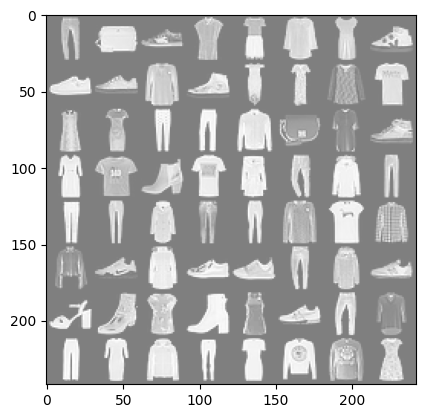

Predicho:  Trouser Bag   Sneaker T-shirt/top
Verdadero:  Trouser Bag   Sneaker Shirt


In [92]:
import torchvision

classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle-boot")

dataiter = iter(test_dataloader)

images, labels = next(dataiter)

imgs = torchvision.utils.make_grid(images)
img = imgs / 2 + 0.5
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

outputs = cnn_loaded(images)
_, predicted = torch.max(outputs, 1)

print('Predicho: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
print('Verdadero: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Using device: cpu
Reporte de Clasificación:
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.88      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.79      0.80      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.78      0.80      0.79      1000
      Sandal       0.96      0.97      0.96      1000
       Shirt       0.70      0.60      0.65      1000
     Sneaker       0.95      0.92      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.93      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000



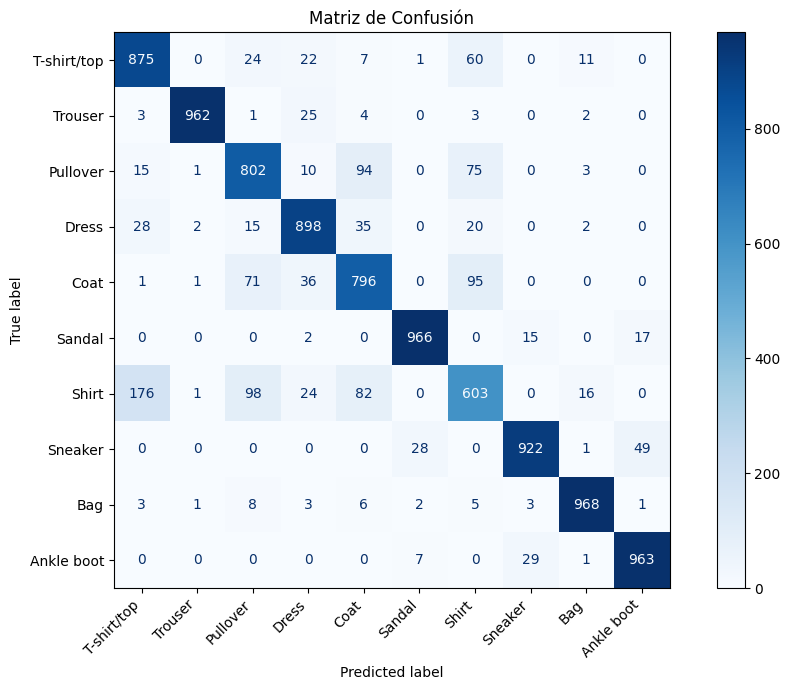

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Configurar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mover modelo al dispositivo
cnn.to(device)

# Etiquetas del dataset FashionMNIST
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Inicializar variables para evaluación
y_real = []
y_pred = []

# Evaluación en el conjunto de prueba
cnn.eval()  # Modo evaluación
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)  # Mover a device
    labels = labels.to(device)  # Mover a device

    # Predicciones sin calcular gradientes
    with torch.no_grad():
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)

    # Guardar etiquetas reales y predichas
    y_real.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

# Mostrar el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_real, y_pred, target_names=classes))

# Generar la matriz de confusión
cm = confusion_matrix(y_real, y_pred)

# Visualizar la matriz de confusión
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Matriz de Confusión")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
